# Food App 

Food image classification. In this notebook, we download the data from the website. Then, we organize the data into the folders and explore images in the data.

**Step1**: Download the data from the website.      
For this project, we use [The Food-101 Data Set](https://www.vision.ee.ethz.ch/datasets_extra/food-101/). The size of the data file is 5GB and it contains 101 food categories with 101'000 images.

The code below download the file into the directory data, and untar the file.

In [1]:
# download the food dataset (and untar)
!wget -P data http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz 
!tar -xzf data/food-101.tar.gz -C data

--2018-12-26 03:35:35--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2018-12-26 03:35:36--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘data/food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  1.24MB/s    in 63m 12s 

2018-12-26 04:38:49 (1.26 MB/s) - ‘data/food-101.tar.gz’ saved [4996278331/4996278331]



In [2]:
# Name of the directory 
data_dir = "data/food-101"

In [3]:
import json

from os import mkdir 
from os import listdir

from shutil import copyfile
from random import shuffle 
from tqdm import tqdm

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  

**Step2**: Read the meta files.       
We read the meta files, `train.json`, `test.json`, `classes.txt` to check the training, testing, and class labels. 

In [4]:
def raed_txt(file_name): 
    with open(file_name, 'r') as f: 
        return [l.strip() for l in f]

def read_json(file_name): 
    with open(file_name, 'r') as f: 
        return json.load(f)

In [6]:
# read meta files
train_json = read_json(data_dir+"/meta/train.json")
test_json = read_json(data_dir+"/meta/test.json")
label_imgs = raed_txt(data_dir+"/meta/classes.txt")

In [7]:
def plot_counts(json_file, set_name):
    labels, counts = [], []
    
    for k, v in train_json.items(): 
        labels.append(k)
        counts.append(len(v))
 
    plt.figure(figsize=(20,10))
    plt.bar(labels, counts)

    plt.title("Image counts for the {} set".format(set_name))
    plt.ylabel("Image count")
    plt.xlabel("Category")
    plt.xticks(rotation='vertical')
    
    plt.show()

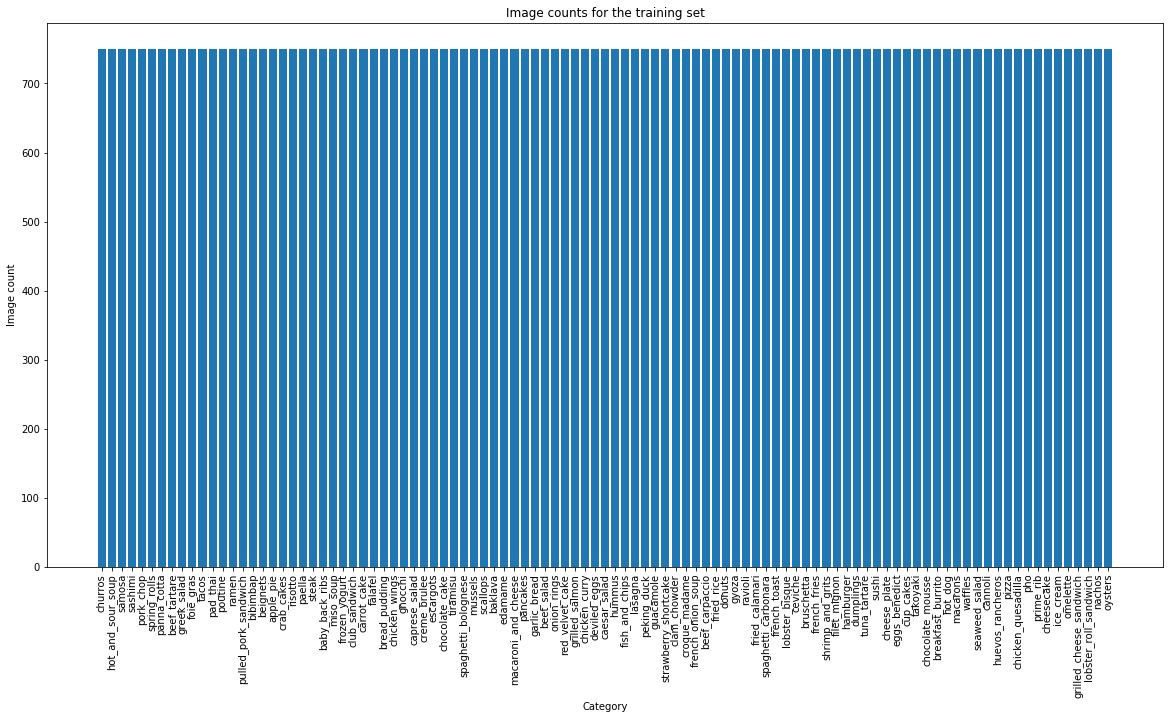

In [8]:
plot_counts(train_json, "training")

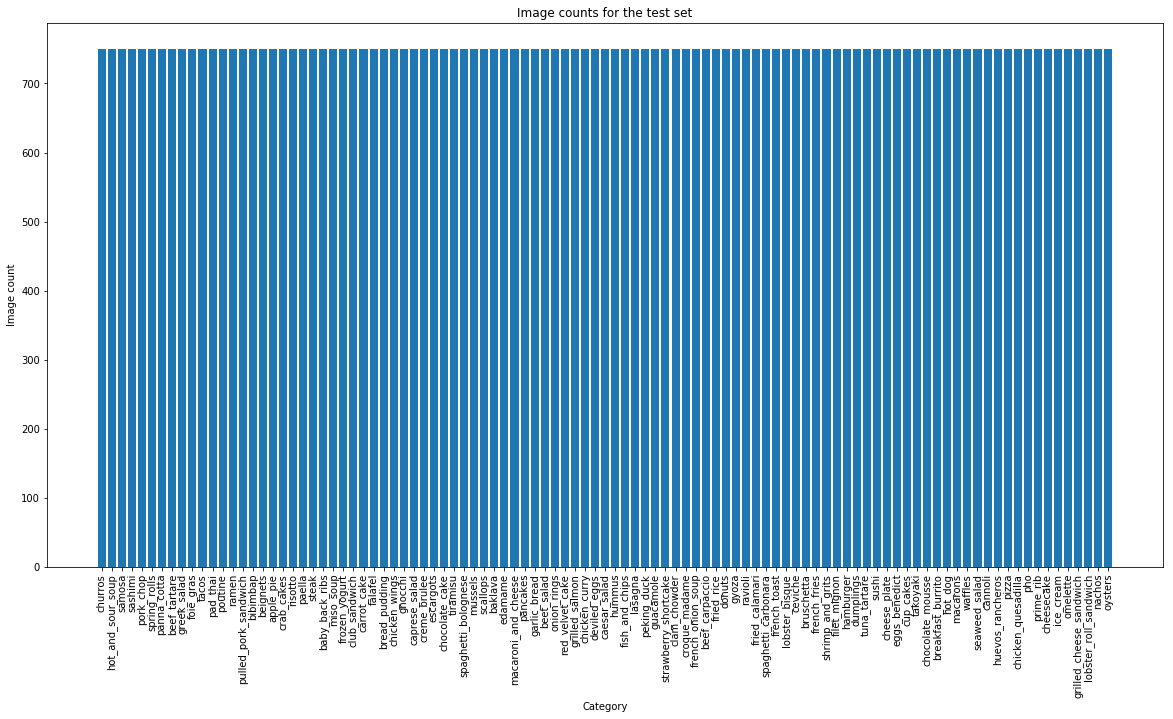

In [9]:
plot_counts(test_json, "test")

**Step3**: Split the training data into a training set and validation set. Then, we put images into test, train, and valid so that we can use `flow_from_directory` from `Keras`.

```
.
├── data
│   ├── food-101
│   │   ├── license_agreement.txt
│   │   ├── meta
│   │   └── README.txt
│   ├── test
│   │   ├── 000.apple_pie
│   │   ├── 001.baby_back_ribs
│   │   ├── 002.baklava
│   │    ....
│   │   ├── 097.takoyaki
│   │   ├── 098.tiramisu
│   │   ├── 099.tuna_tartare
│   │   └── 100.waffles
│   ├── train
│   │   ├── 000.apple_pie
│   │   ├── 001.baby_back_ribs
│   │   ├── 002.baklava
│	│	....
│   │   ├── 097.takoyaki
│   │   ├── 098.tiramisu
│   │   ├── 099.tuna_tartare
│   │   └── 100.waffles
│   └── valid
│       ├── 000.apple_pie
│       ├── 001.baby_back_ribs
│       ├── 002.baklava
│ 		....
│       ├── 097.takoyaki
│       ├── 098.tiramisu
│       ├── 099.tuna_tartare
│       └── 100.waffles

```

In [10]:
# add numbers to each folder
label_imgs = {l:"{:03d}.{}".format(i, l) for i, l in enumerate(label_imgs)}

In [11]:
## Create directories and move files 

In [12]:
mkdir("data/train")
mkdir("data/valid")
mkdir("data/test")

In [13]:
# split the original training set into train and valid dir 
for k in tqdm(train_json.keys()): 
    # generate random indexs to decide train or valid 
    rand_idx = [i for i in range(len(train_json[k]))]
    shuffle(rand_idx)
    
    # split 80-20, train valid 
    n_train = int(len(train_json[k]) * 0.8)
    
    # copy to training 
    mkdir("data/train/"+label_imgs[k])
    for i in range(n_train): 
        src = "data/food-101/images/{}.jpg".format(train_json[k][i])
        dst = "data/train/{}/{}.jpg".format(label_imgs[k], train_json[k][i].replace("/", "_"))
        copyfile(src, dst)
    
    # copy to validation
    mkdir("data/valid/"+label_imgs[k])
    for i in range(n_train, len(rand_idx)):
        src = "data/food-101/images/{}.jpg".format(train_json[k][i])
        dst = "data/valid/{}/{}.jpg".format(label_imgs[k], train_json[k][i].replace("/", "_"))
        copyfile(src, dst)  

100%|██████████| 101/101 [06:03<00:00,  3.55s/it]


In [14]:
# copy test images into test dir 
for k in tqdm(test_json.keys()): 
    mkdir("data/test/"+label_imgs[k])
    for i in range(len(test_json[k])): 
        src = "data/food-101/images/{}.jpg".format(test_json[k][i])
        dst = "data/test/{}/{}.jpg".format(label_imgs[k], test_json[k][i].replace("/", "_"))
        copyfile(src, dst)

100%|██████████| 101/101 [03:59<00:00,  2.34s/it]


In [15]:
# Delete original img data (to save space)
!rm -r data/food-101/images

**Step4**: Explore images        
Pick images randomly from the training and test sets, and see how they look like

In [28]:
# make a list of all training images 
all_train_imgs = [] 
all_test_imgs = [] 
for v in label_imgs.values(): 
    train_dir = "data/train/{}".format(v) 
    all_train_imgs += [train_dir + "/" + d for d in listdir(train_dir)]
    
    test_dir = "data/test/{}".format(v) 
    all_test_imgs += [test_dir + "/" + d for d in listdir(test_dir)]

shuffle(all_train_imgs)
shuffle(all_test_imgs)

In [25]:
def show_imgs(img_list, nrows=5, ncols=7):
    """
    show multiple images in a tile format. 
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(20,17))
    for idx, ax in enumerate(axes.flat):        
        img = cv2.imread(img_list[idx])
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb)

        ax.set_title(img_list[idx].split("/")[-2])
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.grid(False)

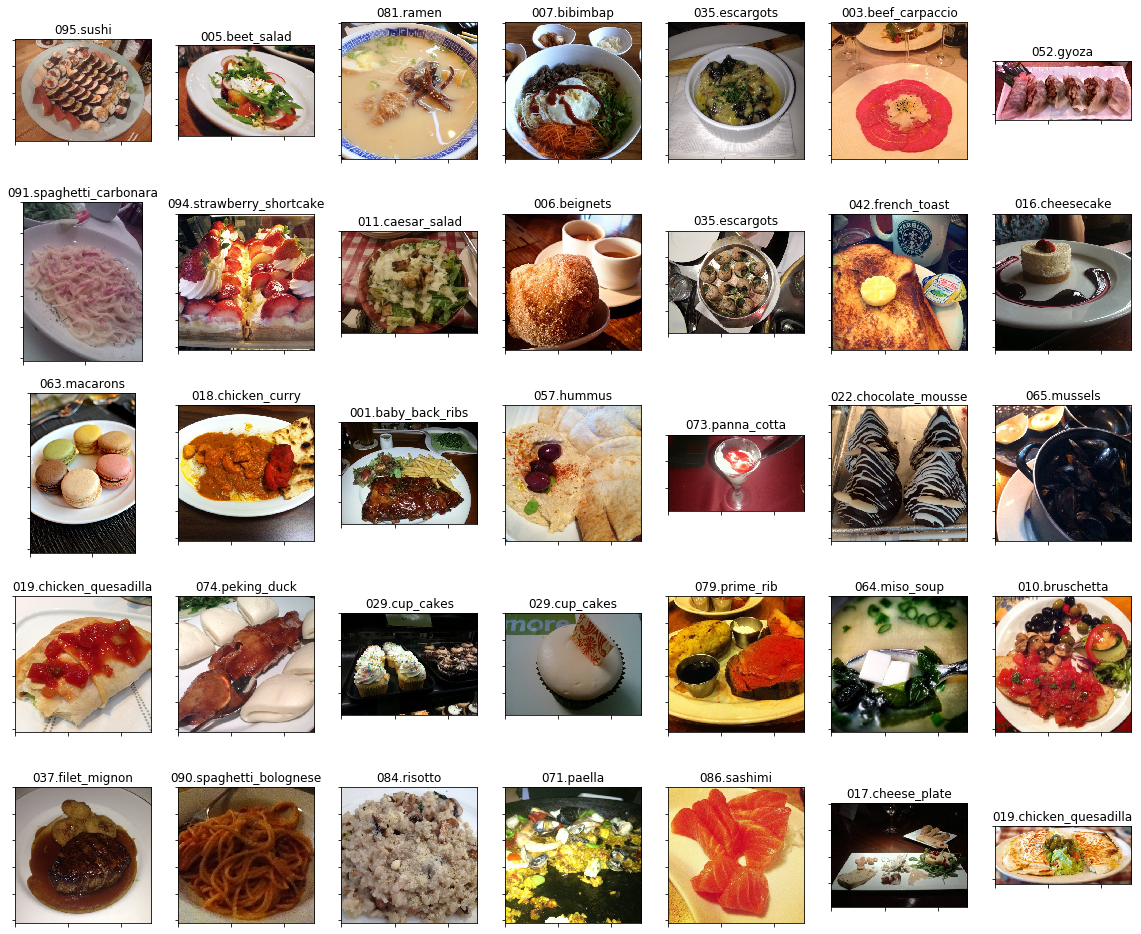

In [29]:
show_imgs(all_train_imgs)

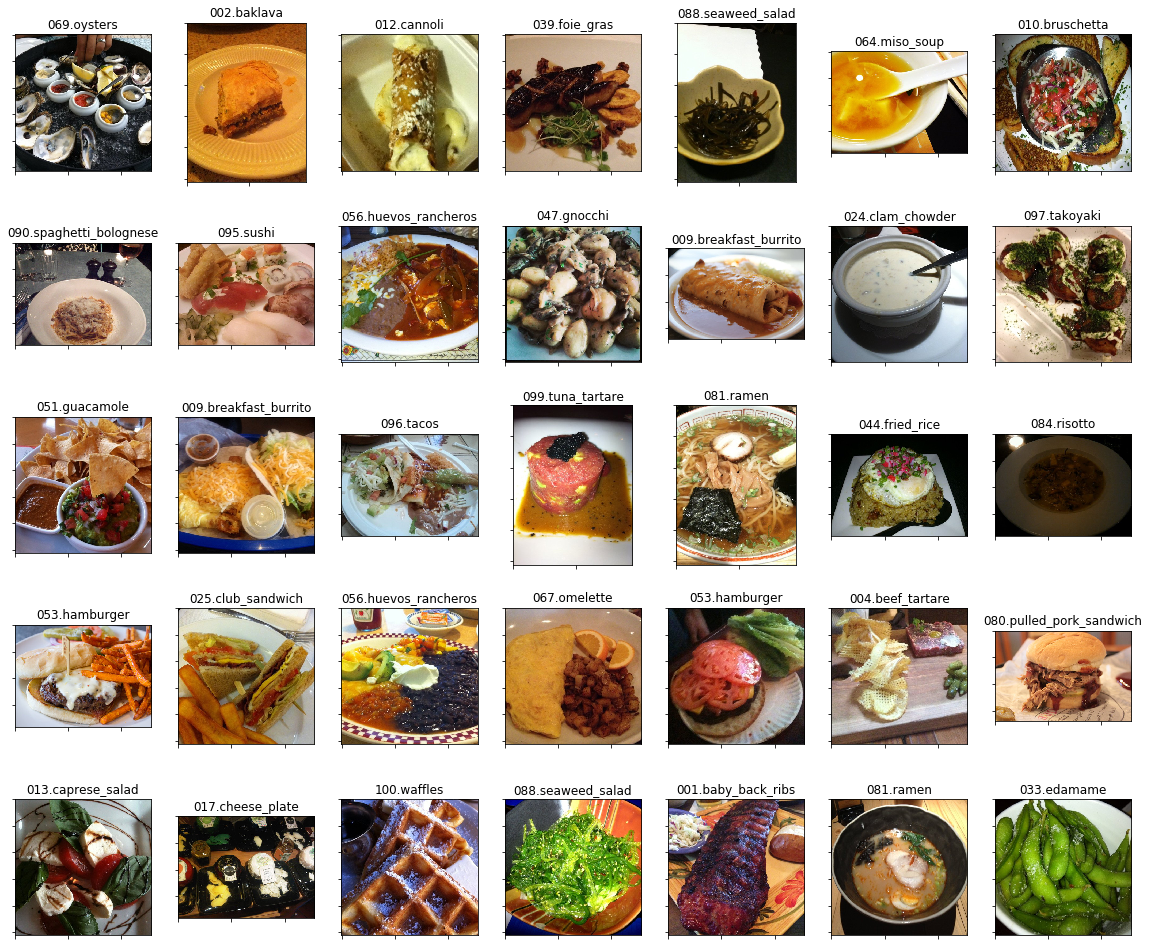

In [30]:
show_imgs(all_test_imgs)